# LifeSnaps Preprocessing Data v1.0
Preprocessem i millorem la neteja de dades previa, optimitzant les columnes per tal d'obtenir bons resultats en l'entrenament del model

### Import de llibreries i warnings

In [2]:
# Exploració de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessament de dades
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Model
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Analisis del model
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset cleaned i visualització dades ràpida

In [4]:
df = pd.read_csv('../data/df_cleaned.csv')
pd.set_option('display.max_columns', None)

display(df.head())
df.info()


,nightly_temperature,rmssd,spo2,full_sleep_breathing_rate,stress_score,daily_temperature_variation,calories,bpm,sedentary_minutes,resting_hr,minutesAsleep,minutesAwake,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,age,gender,bmi,RESTED/RELAXED,TENSE/ANXIOUS,bmi_tipo
0,34.137687,89.603,NaN,14.8,78.0,-1.788325,2351.59,71.701565,713.0,62.073070,445.0,76.0,93.0,NaN,0.987013,0.921642,NaN,8833.0,83.0,<30,MALE,18.4,NaN,NaN,Infrapes
1,33.794544,94.303,NaN,15.8,80.0,-2.462709,2332.08,70.579300,704.0,62.121476,460.0,88.0,94.0,NaN,NaN,0.947566,NaN,9727.0,56.0,<30,MALE,18.4,0.0,0.0,Infrapes
2,34.611011,119.212,NaN,14.6,84.0,-2.385801,2262.30,71.842573,710.0,62.263999,493.0,67.0,96.0,NaN,0.858974,NaN,NaN,8253.0,85.0,<30,MALE,18.4,0.0,0.0,Infrapes
3,34.408304,111.709,NaN,14.8,82.0,-2.124199,2325.10,71.725477,622.0,62.368900,540.0,87.0,93.0,NaN,NaN,NaN,NaN,9015.0,90.0,<30,MALE,18.4,0.0,0.0,Infrapes
4,34.178922,103.034,NaN,15.2,81.0,-2.396873,2586.76,74.401028,647.0,61.965409,493.0,68.0,94.0,0.910256,0.871795,NaN,NaN,12949.0,146.0,<30,MALE,18.4,0.0,0.0,Infrapes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7410 entries, 0 to 7409
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nightly_temperature          3359 non-null   float64
 1   rmssd                        2445 non-null   float64
 2   spo2                         1270 non-null   float64
 3   full_sleep_breathing_rate    2416 non-null   float64
 4   stress_score                 1580 non-null   float64
 5   daily_temperature_variation  3304 non-null   float64
 6   calories                     6635 non-null   float64
 7   bpm                          4804 non-null   float64
 8   sedentary_minutes            3936 non-null   float64
 9   resting_hr                   4422 non-null   float64
 10  minutesAsleep                3547 non-null   float64
 11  minutesAwake                 3551 non-null   float64
 12  sleep_efficiency             3551 non-null   float64
 13  sleep_deep_ratio  

In [5]:
target_col = ['TENSE/ANXIOUS', 'RESTED/RELAXED']
categoric_col = ['age', 'gender', 'bmi_tipo']

numeric_col = df.drop(columns=categoric_col + target_col).columns.tolist()

print('Targets: ', target_col, '\n\nColumnes Categòriques: ', categoric_col, '\n\nColumnes numèriques: ', numeric_col)

Targets:  ['TENSE/ANXIOUS', 'RESTED/RELAXED'] 

Columnes Categòriques:  ['age', 'gender', 'bmi_tipo'] 

Columnes numèriques:  ['nightly_temperature', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'daily_temperature_variation', 'calories', 'bpm', 'sedentary_minutes', 'resting_hr', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1', 'bmi']


In [6]:
df[numeric_col].describe()

,nightly_temperature,rmssd,spo2,full_sleep_breathing_rate,stress_score,daily_temperature_variation,calories,bpm,sedentary_minutes,resting_hr,minutesAsleep,minutesAwake,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,bmi
count,3359.000000,2445.000000,1270.000000,2416.000000,1580.000000,3304.000000,6635.000000,4804.000000,3936.000000,4422.000000,3547.000000,3551.000000,3551.000000,1723.000000,1895.000000,1763.000000,1716.000000,4637.000000,4808.000000,6796.000000
mean,33.771650,40.512290,95.893228,15.321937,76.205063,-1.471843,2186.698998,80.250496,751.908537,66.268735,392.668452,56.625458,93.776401,0.770018,0.792210,0.831862,0.741248,8501.287039,165.972546,23.080224
std,0.905129,20.966442,1.114339,2.698893,6.759862,0.967792,682.372239,9.503785,181.693918,7.234891,96.588530,23.066553,6.296757,0.173967,0.152462,0.127750,0.195661,5341.247629,148.708679,3.445664
min,25.518333,8.327000,89.400000,9.800000,55.000000,-5.688866,431.370000,43.500000,32.000000,44.122845,52.000000,0.000000,34.000000,0.061856,0.238806,0.265823,0.052083,102.000000,0.000000,18.400000
25%,33.305913,25.703000,95.200000,13.400000,71.000000,-2.182988,1674.190000,74.692035,635.000000,61.637034,343.000000,43.000000,93.000000,0.668385,0.695652,0.759716,0.625000,4726.000000,59.000000,20.000000
50%,33.887166,34.187000,95.900000,15.200000,76.000000,-1.415089,2073.600000,79.790362,731.000000,66.504308,401.000000,55.000000,95.000000,0.796875,0.820513,0.857678,0.785714,7600.000000,124.500000,23.000000
75%,34.342720,49.089000,96.700000,17.200000,81.000000,-0.722098,2580.045000,85.165654,836.000000,71.432724,454.000000,70.000000,97.000000,0.908046,0.915254,0.932806,0.893617,11197.000000,230.000000,25.000000
max,36.684793,122.089000,100.000000,29.800000,94.000000,3.393617,5415.540000,153.995380,1200.000000,86.000000,818.000000,358.000000,100.000000,1.000000,1.000000,1.000000,1.000000,32677.000000,1023.000000,30.000000


In [7]:
# Dades nules del dataset
# Percentatge de valors nuls
print('Percentatge de valors nuls:', '\n')
print(df.isnull().sum()/df.shape[0]*100)

Percentatge de valors nuls: 

nightly_temperature            54.669366
rmssd                          67.004049
spo2                           82.860999
full_sleep_breathing_rate      67.395412
stress_score                   78.677463
daily_temperature_variation    55.411606
calories                       10.458839
bpm                            35.168691
sedentary_minutes              46.882591
resting_hr                     40.323887
minutesAsleep                  52.132254
minutesAwake                   52.078273
sleep_efficiency               52.078273
sleep_deep_ratio               76.747638
sleep_wake_ratio               74.426451
sleep_light_ratio              76.207827
sleep_rem_ratio                76.842105
steps                          37.422402
minutes_in_default_zone_1      35.114710
age                             8.286100
gender                          4.993252
bmi                             8.286100
RESTED/RELAXED                 69.095816
TENSE/ANXIOUS              

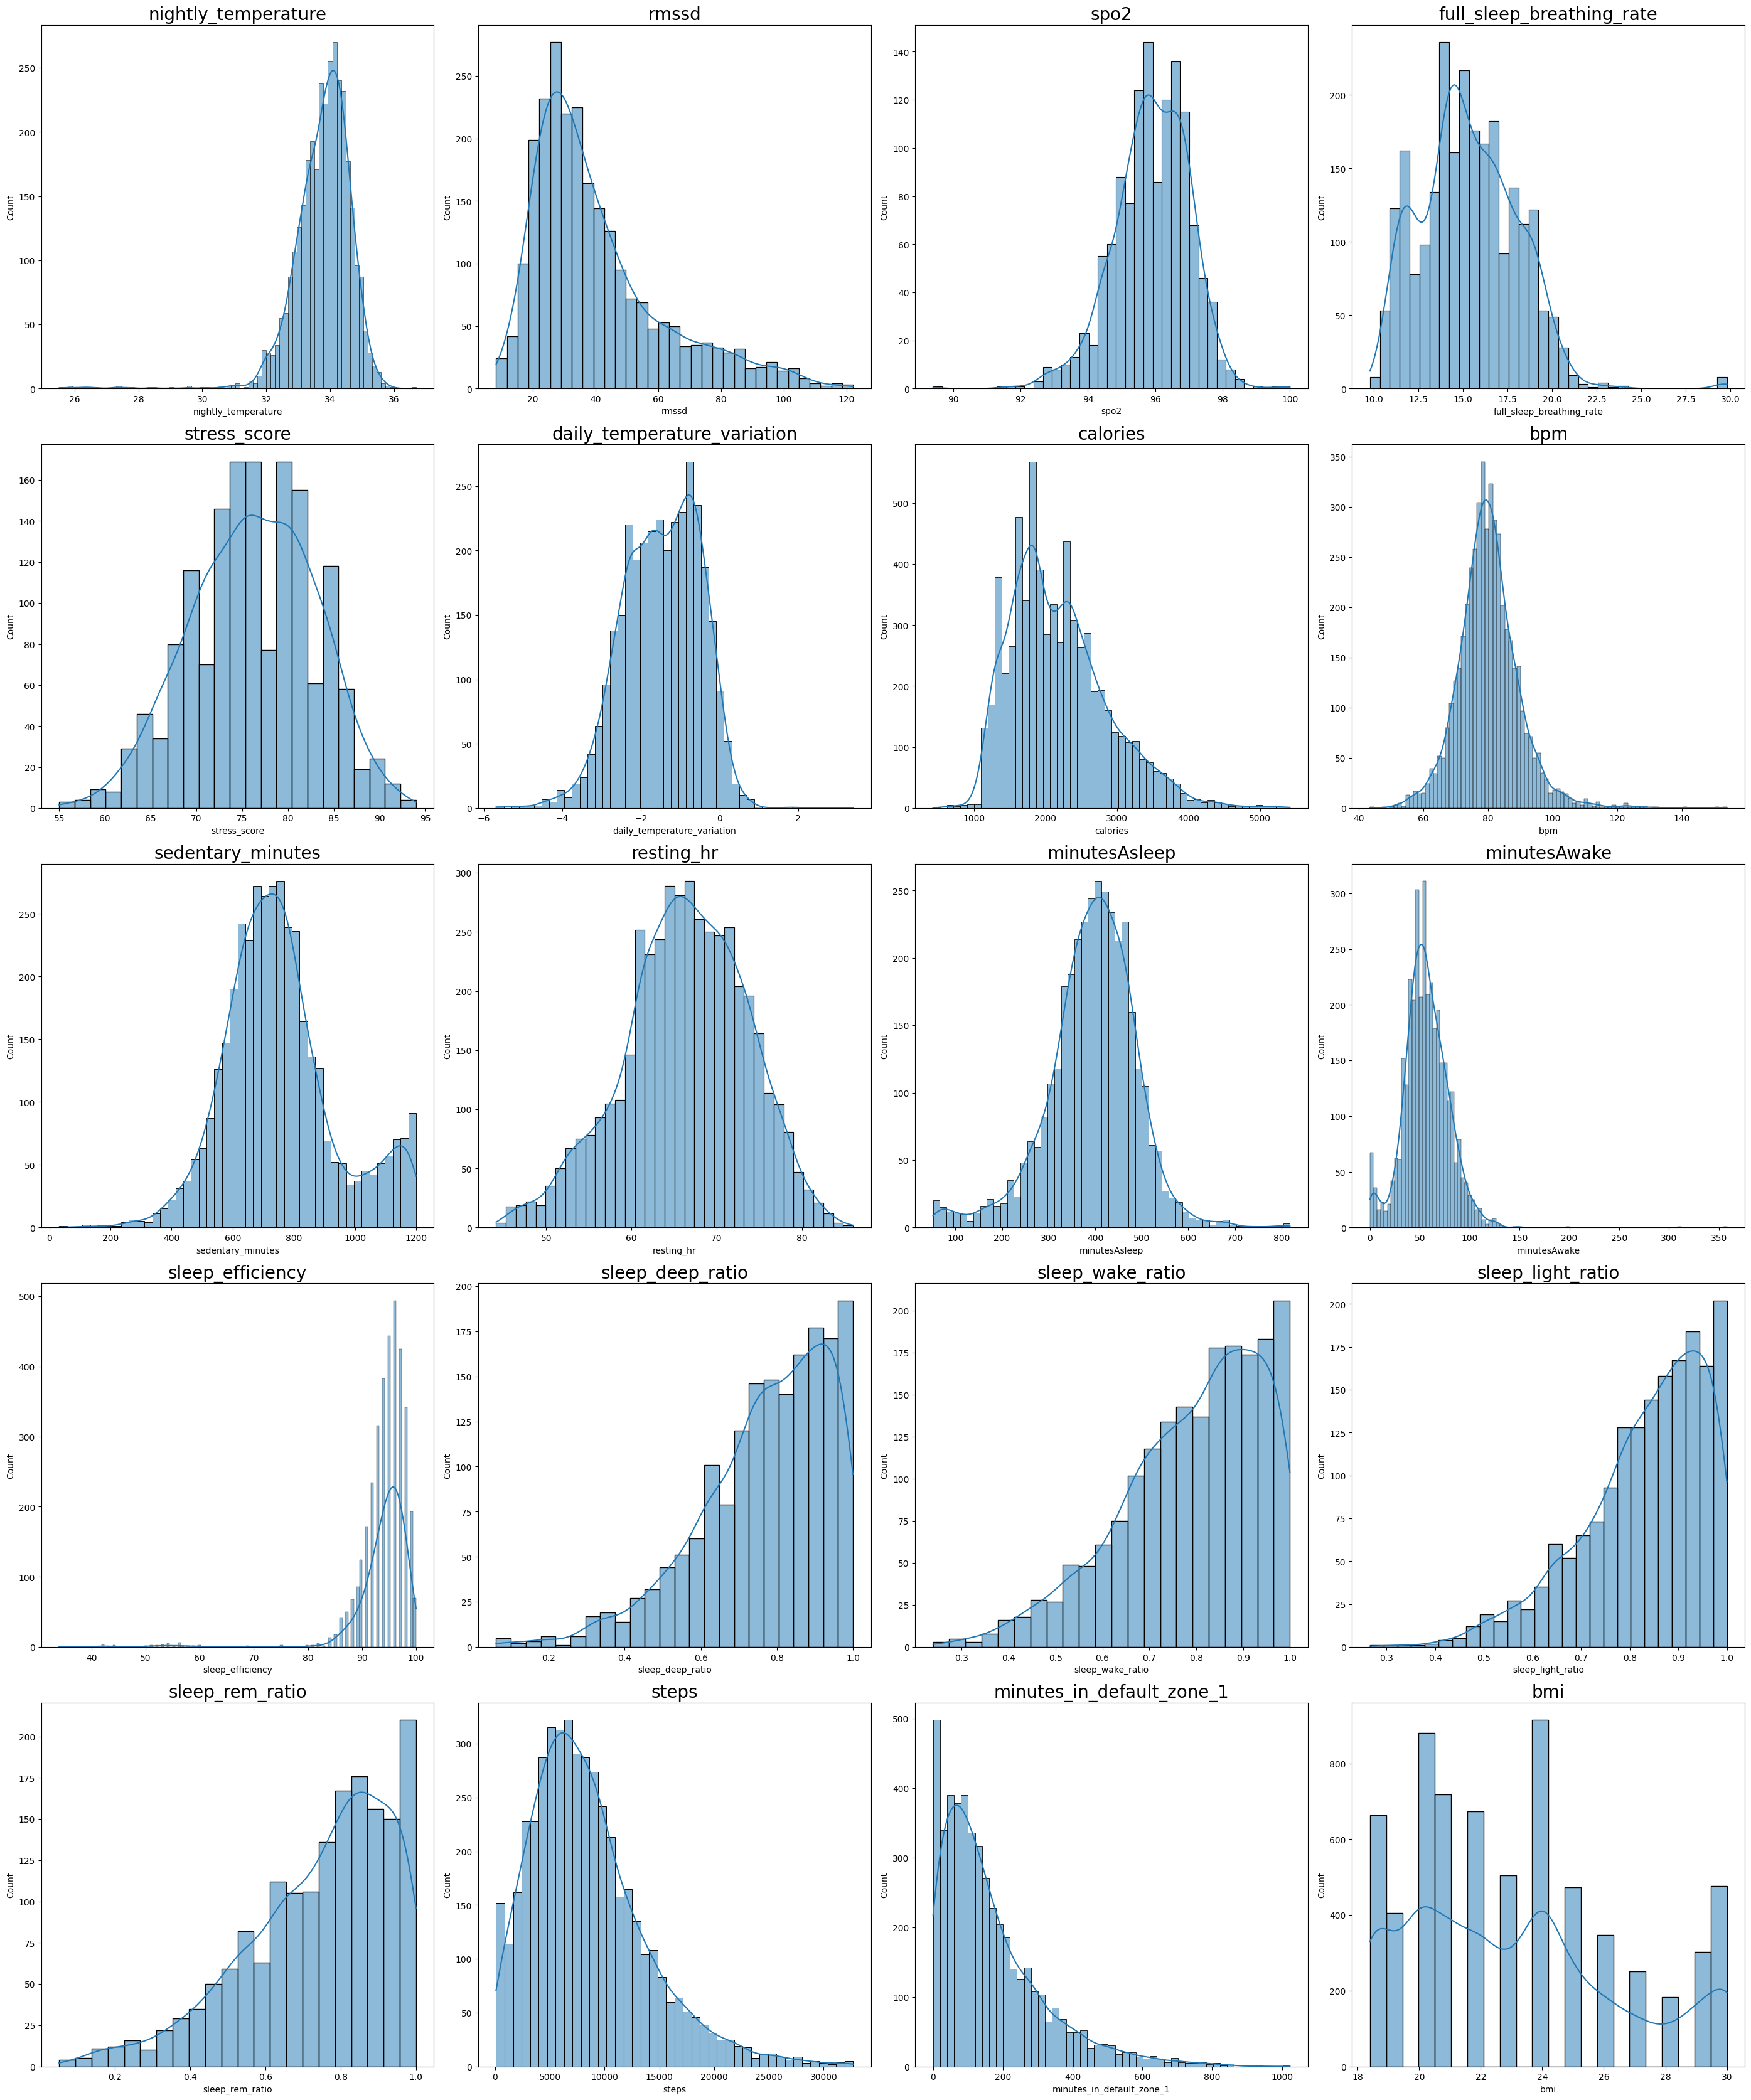

In [8]:
plt.figure(figsize=(28, 100))
plotnumber = 1
for i in numeric_col:
    ax = plt.subplot(15, 4, plotnumber)
    sns.histplot(df[numeric_col][i], kde=True, ax=ax)
    plt.title(i, size=20)
    plotnumber += 1
plt.tight_layout()
plt.show()

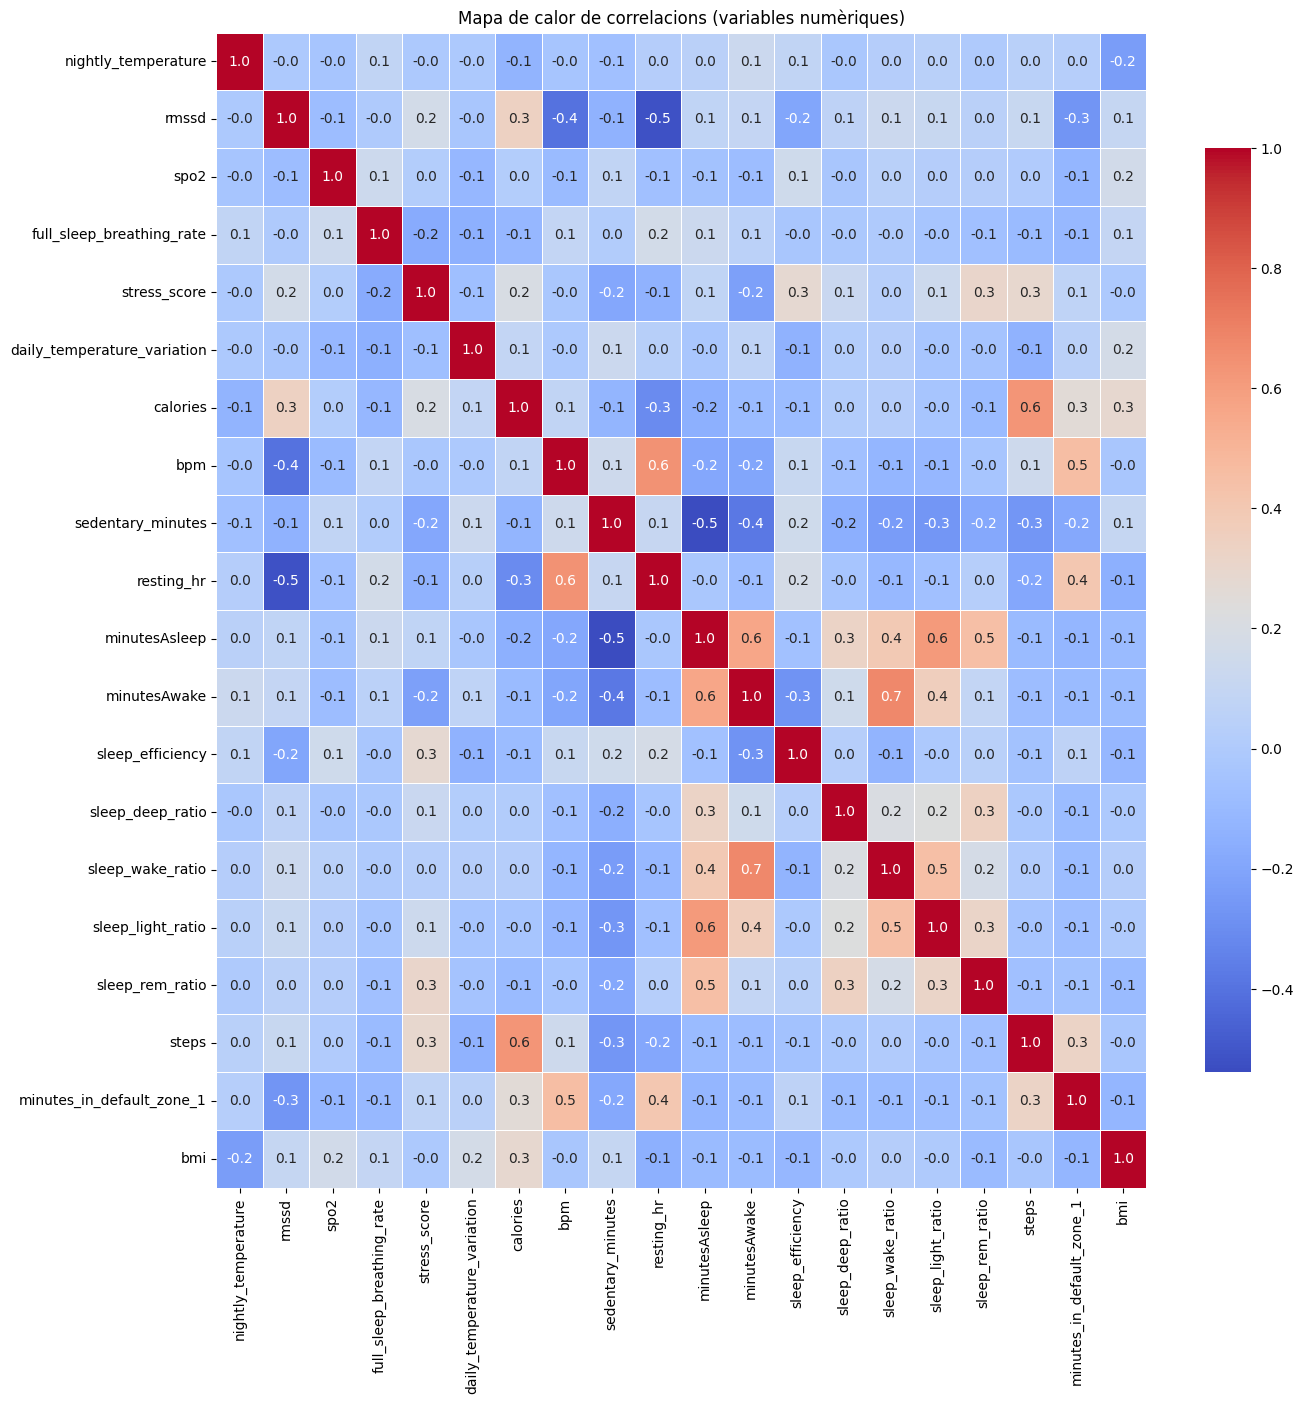

In [9]:
## Numèric vs Numèric: matriu de correlació + scatter de parelles fortes
corr = df[numeric_col].corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5, cbar_kws={"shrink": .8})
plt.title("Mapa de calor de correlacions (variables numèriques)")
plt.show()

## Preprocessament de dades

### Tractament de Valors Absents

Farem imputació simple sobre els valors absents per la mitjana a els valors numerics com heart rate i moda en els valors categorics

In [ ]:
y = df[target_col].copy()
y_tense = y['TENSE/ANXIOUS']
y_rested = y['RESTED/RELAXED']

X = df.drop(columns=target_col).copy() 


In [11]:
# Transformem les columnes amb pipeline

numeric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler())])

categoric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                            ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categoric_pipe, categoric_cols)
])

display(preprocessor)



NameError: name 'numeric_cols' is not defined

In [ ]:
# Visualitzem el dataset preprocessat
X_processed = preprocessor.fit_transform(X)

# Obtenim els noms de les columnes després del pre-processament
noms_columnes = numeric_cols + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categoric_cols))

df_X_prepocessed = pd.DataFrame(X_processed, columns=noms_columnes)

display(df_X_prepocessed.head())
print(df_X_prepocessed.info())

,nightly_temperature,rmssd,spo2,full_sleep_breathing_rate,stress_score,daily_temperature_variation,calories,bpm,sedentary_minutes,resting_hr,minutesAsleep,minutesAwake,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,bmi,age_<30,age_>=30,gender_FEMALE,gender_MALE,bmi_tipo_Infrapes,bmi_tipo_Normal,bmi_tipo_Obes,bmi_tipo_Sobrepes
0,0.494893,4.299689,0.002517,-0.285219,0.626690,-0.537962,0.273314,-1.095694,-0.219147,-0.767623,0.716815,1.264896,-0.321206,0.073792,2.225616,1.108260,0.107287,0.157513,-0.563509,-1.416384,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,-0.065778,4.678631,0.002517,0.363365,1.267388,-1.580679,0.243140,-1.242307,-0.286910,-0.758963,0.940875,2.015538,-0.093985,0.073792,0.092719,1.518071,0.107287,0.368002,-0.785915,-1.416384,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.268270,6.686940,0.002517,-0.414936,2.548782,-1.461765,0.135219,-1.077273,-0.241735,-0.733464,1.433807,0.701915,0.360456,0.073792,0.585419,0.097098,0.107287,0.020954,-0.547034,-1.416384,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.937062,6.082004,0.002517,-0.285219,1.908085,-1.057283,0.232345,-1.092570,-0.904309,-0.714697,2.135862,1.952984,-0.321206,0.073792,0.092719,0.097098,0.107287,0.200364,-0.505848,-1.416384,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.562267,5.382575,0.002517,-0.025786,1.587736,-1.478884,0.637027,-0.743036,-0.716078,-0.786884,1.433807,0.764469,-0.093985,1.413557,0.749652,0.097098,0.107287,1.126612,-0.044560,-1.416384,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7410 entries, 0 to 7409
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nightly_temperature          7410 non-null   float64
 1   rmssd                        7410 non-null   float64
 2   spo2                         7410 non-null   float64
 3   full_sleep_breathing_rate    7410 non-null   float64
 4   stress_score                 7410 non-null   float64
 5   daily_temperature_variation  7410 non-null   float64
 6   calories                     7410 non-null   float64
 7   bpm                          7410 non-null   float64
 8   sedentary_minutes            7410 non-null   float64
 9   resting_hr                   7410 non-null   float64
 10  minutesAsleep                7410 non-null   float64
 11  minutesAwake                 7410 non-null   float64
 12  sleep_efficiency             7410 non-null   float64
 13  sleep_deep_ratio  

In [ ]:
## Split train/test
y_nonan = y.dropna()
df
X_train, X_test, y_train, y_test = train_test_split(df_X_prepocessed, y_nonan, test_size=0.2, random_state=42, stratify=y_nonan)


ValueError: Found input variables with inconsistent numbers of samples: [7410, 2290]

## Entrenament del Model (SMOTE)

In [ ]:
# Definició de models i paràmetres
models = {
    "MLP": MLPClassifier(max_iter=400, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Definim els grids de paràmetres amb prefix
param_grids = {
    "MLP": {
        "clf__hidden_layer_sizes": [(100,), (50,50), (100,50)],
        "clf__alpha": [1e-4, 1e-3],
        "clf__learning_rate_init": [1e-3, 1e-2]
    },
    "SVM": {
        "clf__C": [1, 10, 50],
        "clf__gamma": ["scale", 1e-2, 1e-3]
    },
    "RandomForest": {
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    },
    "GradientBoosting": {
        "clf__n_estimators": [150, 300],
        "clf__learning_rate": [0.1, 0.05],
        "clf__max_depth": [3, 4]
    }
}

# Cross‑validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop de GridSearchCV
results = []

for nom, model in models.items():
    print(f"\nBuscant els millors paràmetres amb GridSearchCV per {nom}")
    pipeline = ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", model)
    ])
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grids[nom],
        cv=cv,
        scoring="recall",
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)

    # Emmagatzema resultats
    results.append({
        "model":       nom,
        "millor_sensibilitat": gs.best_score_,
        "millors_parametres": gs.best_params_
    })

    print(f"{nom} → Millor Sensibilitat: {gs.best_score_:.3f}")
    print("Params òptims:", gs.best_params_)

# 5) Converteix a DataFrame i mostra ordenat
results_df = pd.DataFrame(results).sort_values(
    by="millor_sensibilitat", ascending=False
).reset_index(drop=True)


 Buscant els millors paràmetres amb GridSearchCV per MLP
MLP → Millor Sensibilitat: 0.333
Params òptims: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01}

 Buscant els millors paràmetres amb GridSearchCV per SVM
SVM → Millor Sensibilitat: 0.752
Params òptims: {'clf__C': 1, 'clf__gamma': 0.001}

 Buscant els millors paràmetres amb GridSearchCV per RandomForest
RandomForest → Millor Sensibilitat: 0.315
Params òptims: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

 Buscant els millors paràmetres amb GridSearchCV per GradientBoosting
GradientBoosting → Millor Sensibilitat: 0.305
Params òptims: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 150}


In [ ]:
display(results_df)

,model,millor_sensibilitat,millors_parametres
0,SVM,0.752222,"{'clf__C': 1, 'clf__gamma': 0.001}"
1,MLP,0.332593,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
2,RandomForest,0.315216,"{'clf__max_depth': 10, 'clf__min_samples_split..."
3,GradientBoosting,0.305154,"{'clf__learning_rate': 0.05, 'clf__max_depth':..."


### Tria del millor model i pipeline (SMOTE)



Millor model: SVM

Mètriques sobre test:
 • Exactitud (Accuracy) :  0.701
 • Precisió             :  0.366
 • Sensibilitat         :  0.485
 • F1-score             :  0.417
 • ROC-AUC              :  0.661



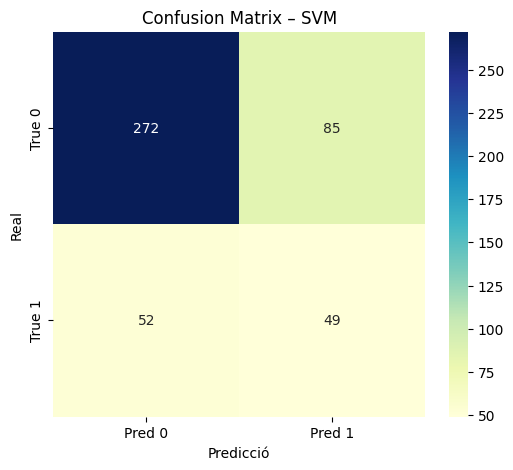

In [ ]:

# millor model

millor_model = results_df.iloc[0].to_dict()
model_name   = millor_model["model"]
print(f"\nMillor model: {model_name}\n")

# Reentrena pipeline amb el model escollit
best_estimator = models[model_name]
millor_pipeline = ImbPipeline([
    ("prep",  preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf",   best_estimator)
])

print(best_estimator)
millor_pipeline.fit(X_train, y_train)


# Prediccions
y_pred = millor_pipeline.predict(X_test)
y_pred_proba = millor_pipeline.predict_proba(X_test)[:, 1]


# Mètriques numèriques
acc     = accuracy_score(y_test, y_pred)
prec    = precision_score(y_test, y_pred)
rec     = recall_score(y_test, y_pred)
f1      = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Mètriques sobre test:")
print(f" • Exactitud (Accuracy) :  {acc:.3f}")
print(f" • Precisió             :  {prec:.3f}")
print(f" • Sensibilitat         :  {rec:.3f}")
print(f" • F1-score             :  {f1:.3f}")
print(f" • ROC-AUC              :  {roc_auc:.3f}\n")


# Matriu de confusió
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title(f"Confusion Matrix – {model_name}")
plt.ylabel("Real")
plt.xlabel("Predicció")
plt.show()

## Entrenament del Model (BorderlineSMOTE)

In [ ]:
# Definició de models i paràmetres
models = {
    "MLP": MLPClassifier(max_iter=400, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Definim els grids de paràmetres amb prefix
param_grids = {
    "MLP": {
        "clf__hidden_layer_sizes": [(100,), (50,50), (100,50)],
        "clf__alpha": [1e-4, 1e-3],
        "clf__learning_rate_init": [1e-3, 1e-2]
    },
    "SVM": {
        "clf__C": [1, 10, 50],
        "clf__gamma": ["scale", 1e-2, 1e-3]
    },
    "RandomForest": {
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    },
    "GradientBoosting": {
        "clf__n_estimators": [150, 300],
        "clf__learning_rate": [0.1, 0.05],
        "clf__max_depth": [3, 4]
    }
}

# Cross‑validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop de GridSearchCV
results = []

for nom, model in models.items():
    print(f"\n Buscant els millors paràmetres amb GridSearchCV per {nom}")
    pipeline = ImbPipeline([
        ("prep", preprocessor),
        ("smote", BorderlineSMOTE(sampling_strategy=0.8, random_state=42)),
        ("clf", model)
    ])
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grids[nom],
        cv=cv,
        scoring="recall",
        n_jobs=-1,
        verbose=2
    )
    gs.fit(X_train, y_train)

    # Emmagatzema resultats
    results.append({
        "model":       nom,
        "millor_sensibilitat": gs.best_score_,
        "millors_parametres": gs.best_params_
    })

    print(f"{nom} → Millor Sensibilitat: {gs.best_score_:.3f}")
    print("Params òptims:", gs.best_params_)

# 5) Converteix a DataFrame i mostra ordenat
results_df = pd.DataFrame(results).sort_values(
    by="millor_sensibilitat", ascending=False
).reset_index(drop=True)


 Buscant els millors paràmetres amb GridSearchCV per MLP
Fitting 5 folds for each of 12 candidates, totalling 60 fits
MLP → Millor Sensibilitat: 0.357
Params òptims: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50, 50), 'clf__learning_rate_init': 0.001}

 Buscant els millors paràmetres amb GridSearchCV per SVM
Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVM → Millor Sensibilitat: 0.449
Params òptims: {'clf__C': 50, 'clf__gamma': 0.001}

 Buscant els millors paràmetres amb GridSearchCV per RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForest → Millor Sensibilitat: 0.251
Params òptims: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

 Buscant els millors paràmetres amb GridSearchCV per GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits
GradientBoosting → Millor Sensibilitat: 0.241
Params òptims: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 300}


In [ ]:
display(results_df)

,model,millor_sensibilitat,millors_parametres
0,SVM,0.449444,"{'clf__C': 50, 'clf__gamma': 0.001}"
1,MLP,0.357407,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
2,RandomForest,0.250710,"{'clf__max_depth': 10, 'clf__min_samples_split..."
3,GradientBoosting,0.240679,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."


### Tria del millor model i pipeline (BorderlineSMOTE)


Millor model: SVM

Mètriques sobre test:
 • Exactitud (Accuracy) :  0.716
 • Precisió             :  0.382
 • Sensibilitat         :  0.465
 • F1-score             :  0.420
 • ROC-AUC              :  0.666



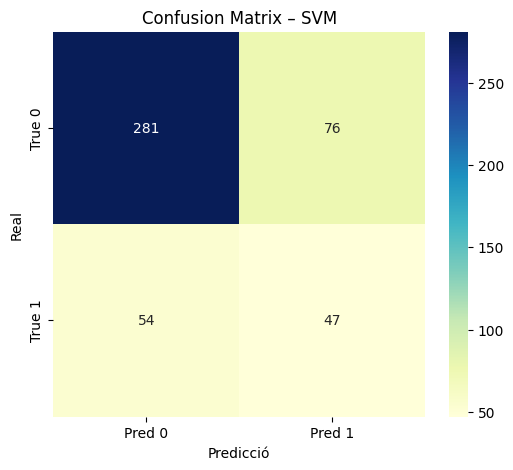

In [ ]:
# millor model

millor_model = results_df.iloc[0].to_dict()
model_name   = millor_model["model"]
print(f"\nMillor model: {model_name}\n")

# Reentrena pipeline amb el model escollit
best_estimator = models[model_name]
millor_pipeline = ImbPipeline([
    ("prep",  preprocessor),
    ("smote", BorderlineSMOTE(sampling_strategy=0.8, random_state=42)),
    ("clf",   best_estimator)
])
millor_pipeline.fit(X_train, y_train)


# Prediccions
y_pred = millor_pipeline.predict(X_test)
y_pred_proba = millor_pipeline.predict_proba(X_test)[:, 1]


# Mètriques numèriques
acc     = accuracy_score(y_test, y_pred)
prec    = precision_score(y_test, y_pred)
rec     = recall_score(y_test, y_pred)
f1      = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Mètriques sobre test:")
print(f" • Exactitud (Accuracy) :  {acc:.3f}")
print(f" • Precisió             :  {prec:.3f}")
print(f" • Sensibilitat         :  {rec:.3f}")
print(f" • F1-score             :  {f1:.3f}")
print(f" • ROC-AUC              :  {roc_auc:.3f}\n")


# Matriu de confusió
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title(f"Confusion Matrix – {model_name}")
plt.ylabel("Real")
plt.xlabel("Predicció")
plt.show()